In [4]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem


DATAPATH = "../data"

In [ ]:
df = pd.read_csv(os.path.join(DATAPATH, "OSAMasterList.csv"))
df = df[["OSA_ID","Target % activity", "SMILES_parent" ]]
df.rename({"OSA_ID":"ID", "Target % activity":"activity", "SMILES_parent":"SMILES"}, axis=1, inplace=True)
df.dropna(subset=["activity"], inplace=True)
df["activity"] = df["activity"].apply(lambda x: float(x.split(" &")[0]))
df = df[df["activity"]>=0] #eliminate negative values as errors

In [ ]:
bin_act = []
for i in df["activity"].tolist():
    if i > 20:
        bin = 0
    else:
        bin = 1
    bin_act += [bin]
df["bin_act"]=bin_act

print(len(df[df["bin_act"]==1]))
print(len(df[df["bin_act"]==0]))

In [ ]:
df.to_csv(os.path.join(DATAPATH, "murD_inhibition.csv"), index=False)

In [ ]:
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["SMILES"], df["bin_act"], test_size=0.2)

mdl = MorganBinaryClassifier()
mdl.fit(X_train, y_train)
y_pred = mdl.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
#plt.savefig(os.path.join("../figures", "roc_auto6.png"))

In [ ]:
mdl._auroc

In [ ]:
import joblib
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier

#Train model with all data
X = df["SMILES"]
y = df["bin_act"]

mdl = MorganBinaryClassifier()
mdl.fit(X, y)
joblib.dump(mdl,"../models/morganclf.joblib")

In [ ]:
mdl._auroc

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#check model performance over real training data
y_pred = mdl.predict_proba(X)

fpr_test, tpr_test, _ = metrics.roc_curve(y, y_pred[:,1])
auc_test = metrics.roc_auc_score(y, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')

In [ ]:
#Filter list of molecules for docking
dk = pd.read_csv("../data/docking/full_lib/smiles.smi", sep='\t', names=['smiles', 'id'])
smi = dk["smiles"]

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

preds = []
for chunk in chunker(smi, 10000):
    p = mdl.predict_proba(chunk)
    preds += [p]

In [ ]:
proba1 = []
for x in preds:
    p1_chunk = x[:,1]
    proba1 += list(p1_chunk)
    

In [ ]:
plt.hist(proba1, color = "#50285a")
plt.savefig("../figures/inhibitory_pred.png", dpi=300)

In [ ]:
dk["proba1"]=proba1
dk.to_csv("../data/inhibitory_pred.csv", index=False)
len(dk[dk["proba1"]>= 0.99])

In [5]:
import joblib
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier
import pandas as pd

mdl = joblib.load("../models/morganclf.joblib")

#PReds against Docking results
df = pd.read_csv(os.path.join(DATAPATH,"docking/docking_MurD/structures/SagaMurD_Frag373/docking_scores.tsv"),sep='\t', header=0)
smi = df["smiles"]

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

preds = []
for chunk in chunker(smi, 10000):
    p = mdl.predict_proba(chunk)
    preds += [p]

In [6]:
proba1 = []
for x in preds:
    p1_chunk = x[:,1]
    proba1 += list(p1_chunk)

In [9]:
df["proba_inh"] = proba1

In [18]:
df.head()

,title,score,smiles,class,proba_inh
0,0091-0033,-10.04740,O=C(c1ccc(C(=O)c2ccc3c4c(cccc24)CC3)cc1)c1ccc(...,0,0.424802
1,0099-0275,-11.29620,CN(C)C=C(C#N)C(=O)N=C1CCCN1C,0,0.005337
2,0143-0003,-22.14470,Nc1nonc1N=[N+]([O-])c1nonc1N,1,0.009891
3,0149-0038,-9.55463,CC(C)(c1cc(CN2CCCCC2)c(O)c(CN2CCCCC2)c1)c1cc(C...,0,0.044309
4,0270-0069,-5.67202,O=[N+]([O-])C12CN3CN(CN(C3)C1)C2,0,0.002732


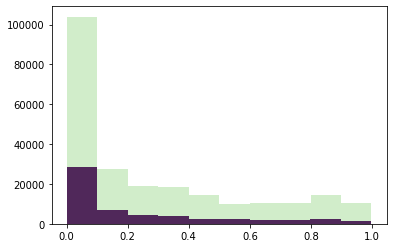

In [25]:
import matplotlib.pyplot as plt
neg = df[df["class"]==0]
pos = df[df["class"]==1]

plt.hist(neg["proba_inh"], color = "#bee6b4", alpha=0.7)
plt.hist(pos["proba_inh"], color = "#50285a",)
plt.savefig("../figures/hist_docking_inh.png", dpi=300)

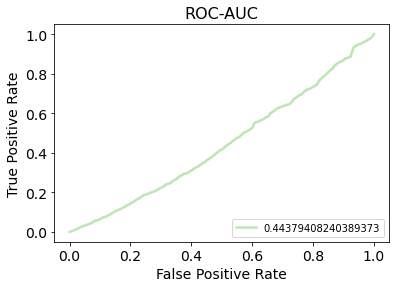

In [22]:
#roc curve as if class was y_true
from sklearn import metrics

y_t = df["class"]
y_p = df["proba_inh"]

fpr_test, tpr_test, _ = metrics.roc_curve(y_t, y_p)
auc_test = metrics.roc_auc_score(y_t, y_p)

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
plt.savefig("../figures/roc_docking_inhibition.png", dpi=300)

# Predictions from Ersilia Library on new compounds

Text(0.5, 1.0, 'eos7pw8 - SA')

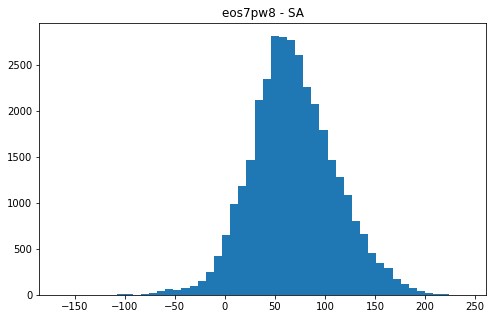

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os

eos7pw8 = pd.DataFrame()
for file in os.listdir("../results"):
    if "eos7pw8" in file:
        df = pd.read_csv(os.path.join("../results/",file))
        eos7pw8 = eos7pw8.append(df)
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(eos7pw8["score"], bins=50)
ax.set_title("eos7pw8 - SA")

Text(0.5, 1.0, 'eos2r5a - RA')

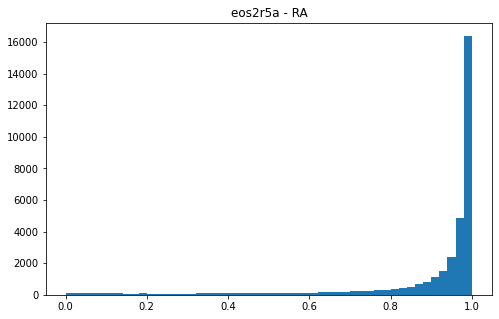

In [23]:
eos2r5a = pd.DataFrame()
for file in os.listdir("../results"):
    if "eos2r5a" in file:
        df = pd.read_csv(os.path.join("../results/",file))
        eos2r5a = eos2r5a.append(df)
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(eos2r5a["ra_score"], bins=50)
ax.set_title("eos2r5a - RA")

Text(0.5, 1.0, 'Tanimoto Similarity to Training Set')

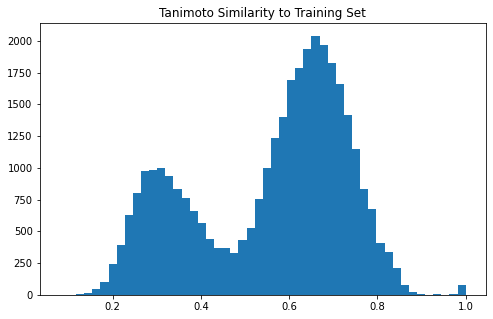

In [29]:
tan = pd.DataFrame()
for file in os.listdir("../results"):
    if "tanimoto" in file:
        df = pd.read_csv(os.path.join("../results/",file))
        tan = tan.append(df)
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(tan["ts_train"], bins=50)
ax.set_title("Tanimoto Similarity to Training Set")

Text(0.5, 1.0, 'Tanimoto Similarity to Known Inhibitors')

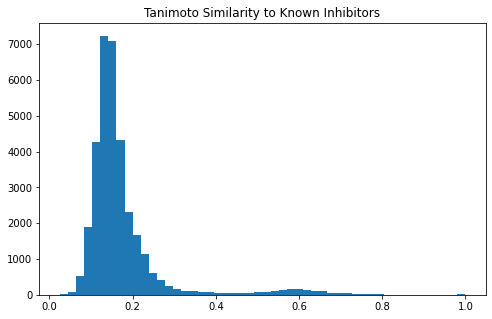

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(tan["ts_known"], bins=50)
ax.set_title("Tanimoto Similarity to Known Inhibitors")

Text(0.5, 1.0, 'Tanimoto Similarity to Pocketvec hits')

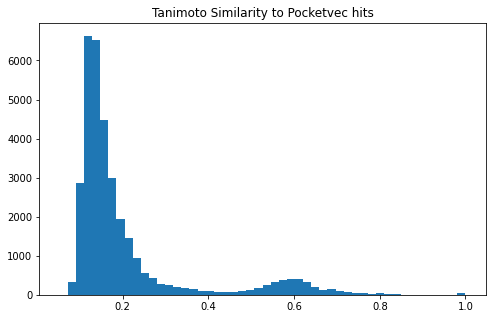

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.hist(tan["ts_pocketvec"], bins=50)
ax.set_title("Tanimoto Similarity to Pocketvec hits")

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
sdf_file = '../data/628smiles_vendors.sdf'
df = PandasTools.LoadSDF(sdf_file,smilesName='SMILES', includeFingerprints=False)
df.drop(columns="ROMol", inplace=True)


In [6]:
df.columns

Index(['Entry', 'title', 'rigid docking scores', 'InChIKey', 'ID', 'SMILES',
       'ZINC', 'eMolecules', 'Pubchem', 'Mcule', 'MolPort', 'ChEMBL',
       'SureChEMBL Patents', 'Japanese Chemicals'],
      dtype='object')

In [21]:
import numpy as np
print(df[df["ZINC"].notnull()].shape)
print(df[df["eMolecules"].notnull()].shape)
print(df[df["Pubchem"].notnull()].shape)
print(df[df["Mcule"].notnull()].shape)
print(df[df["MolPort"].notnull()].shape)
print(df[df["ChEMBL"].notnull()].shape)
print(df[df["SureChEMBL Patents"].notnull()].shape)
print(df[df["Japanese Chemicals"].notnull()].shape)


(78, 14)
(67, 14)
(144, 14)
(113, 14)
(73, 14)
(35, 14)
(23, 14)
(3, 14)


In [69]:
import math
zinc = []
for i,r in df.iterrows():
    if isinstance(r["ZINC"], str):
        zinc += [i]
emol=[]
for i,r in df.iterrows():
    if isinstance(r["eMolecules"], str):
        emol += [i]
pubchem = []
for i,r in df.iterrows():
    if isinstance(r["Pubchem"], str):
        zinc += [i]
mcule=[]
for i,r in df.iterrows():
    if isinstance(r["Mcule"], str):
        mcule += [i]
molport=[]
for i,r in df.iterrows():
    if isinstance(r["MolPort"], str):
        molport += [i]
chembl=[]
for i,r in df.iterrows():
    if isinstance(r["ChEMBL"], str):
        chembl += [i]
surech =[]
for i,r in df.iterrows():
    if isinstance(r["SureChEMBL Patents"], str):
        surech += [i]
jap = []
for i,r in df.iterrows():
    if isinstance(r["Japanese Chemicals"], str):
        jap += [i]

In [71]:
idx = set(zinc+emol+pubchem+mcule+molport+chembl+surech+jap)
len(idx)

170

In [85]:
c = pd.read_csv("../submission/candidates_628.csv")
c["commercial"] = np.nan
for i in idx:
    c.at[i, "commercial"] = 1
c[c["commercial"]==1]

c.to_csv("../submission/candidates_628_com.csv", index=False)


In [89]:
c_sel = c[c["commercial"]==1]
c_sel[["title", "smiles", "score", "ph4_matches"]].to_csv("../submission/commercial_170.csv", index=False)